Initial Data (first 10 rows):
          gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  \
sample1      12     21      4    130     18      0     16     54     49   
sample2       1     44      2     63     11     10     70     32     57   
sample3       4      4     11    180     21      3     28     34     65   
sample4       1     10      2    100     44      9     28     16     33   
sample5       1     11      6    135     16      2     32     29     31   
sample6       0      8      2     36     26      3     36     42     42   
sample7       0     14     17    159     11     19     39     22     38   
sample8       2     19     11     60     19      2     41     83     46   
sample9       5     19      9     66      7      3     13     25     52   
sample10     18     11      8    157     35      0     31     52     37   

          gene10  
sample1        3  
sample2        9  
sample3        2  
sample4        9  
sample5        5  
sample6       17  
sample7    

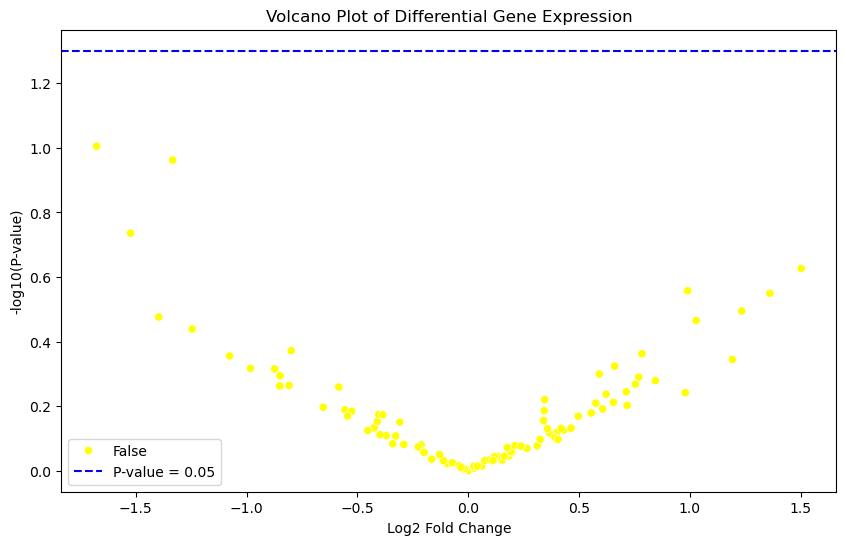

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.utils import load_example_data

# Data Initialization

counts_df = load_example_data()

# Recreate metadata (Control vs Treatment)
conditions = ['Control'] * (counts_df.shape[1] // 2) + ['Treatment'] * (counts_df.shape[1] // 2)
metadata_df = pd.DataFrame({'condition': conditions}, index=counts_df.columns)

print("Initial Data (first 10 rows):")
print(counts_df.head(10))

# Differential Gene Expression Analysis

# Define conditions
conditions = metadata_df['condition'].tolist()

# Log2 transform to stabilize variance
df_log = np.log2(counts_df + 1)

# Perform differential expression analysis
results = []
for gene in df_log.index:
    y = df_log.loc[gene].values.astype(float)
    X = pd.get_dummies(conditions, drop_first=True).astype(float)
    X = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    # Extract log2 fold change and p-value
    log2_fc = model.params.iloc[1]
    fold_change = 2 ** log2_fc
    p_value = model.pvalues.iloc[1]

    results.append([gene, log2_fc, fold_change, p_value])

# Store results in DataFrame
results_df = pd.DataFrame(results, columns=['Gene', 'Log2_FC', 'Fold_Change', 'P-value'])
# Multiple testing correction (FDR)
results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]
print("\nDifferential Expression Results (first 10 rows):")
print(results_df.head(10))

# Data Visualization (Volcano Plot)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='Log2_FC',
    y=-np.log10(results_df['P-value']),
    hue=results_df['Adj_P-value'] < 0.05,
    palette={True: 'red', False: 'yellow'}
)

# Horizontal line at p-value = 0.05 threshold
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='P-value = 0.05')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.legend()
plt.show()


In [10]:
import inspect
from pydeseq2.utils import load_example_data

print(inspect.getsource(load_example_data))


def load_example_data(
    modality: Literal["raw_counts", "metadata"] = "raw_counts",
    dataset: Literal["synthetic"] = "synthetic",
    debug: bool = False,
    debug_seed: int = 42,
) -> pd.DataFrame:
    """Load synthetic example data.

    May load either metadata or rna-seq data. For now, this function may only return the
    synthetic data provided as part of this repo, but new datasets might be added in the
    future.

    Parameters
    ----------
    modality : str
        Data modality. "raw_counts" or "metadata".

    dataset : str
        The dataset for which to return gene expression data.
        If "synthetic", will return the synthetic data that is used for CI unit tests.
        (default: ``"synthetic"``).

    debug : bool
        If true, subsample 10 samples and 100 genes at random.
        (Note that the "synthetic" dataset is already 10 features 100.)
        (default: ``False``).

    debug_seed : int
        Seed for the debug mode. (default: ``42``).

    